In [1]:
%matplotlib inline
import quantstats_custom as qs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
def vdir(obj):
    return [x for x in dir(obj) if not x.startswith('_')]
# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [2]:
# fetch the daily returns for a stock
tickerName = 'BTC-USD'
stock = qs.utils.download_returns(tickerName)

sharpe=0.8537516112691859
return=43.19543169885926
momentum         mean=0.9515688359001888
momentum_simple  mean=1.0038598027829628
rolling_sharpe   mean=1.0203036219415984
hodl             mean=1.0


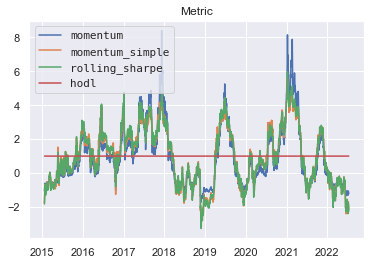

momentum         signal mean=0.8173230437972685
momentum_simple  signal mean=0.8173230437972687
rolling_sharpe   signal mean=0.8173230437972687
hodl             signal mean=0.8173230437972682


,Close,Close,Close,Close,Close
Date,,,,,
2017-01-01,0.035883,0.007805,0.007356,0.007334,0.005445
2017-01-02,0.023464,0.005104,0.004810,0.004796,0.003560


,Close,Close,Close,Close,Close
Date,,,,,
2022-07-12,-0.032380,-1.183478,-2.028825,-2.088373,1.0
2022-07-13,0.045962,-1.212775,-2.134351,-2.254156,1.0


momentum         cagr=18.76% sharpe=1.236 vol=10.00% sortino=1.934
momentum_simple  cagr=18.97% sharpe=1.249 vol=10.00% sortino=1.952
rolling_sharpe   cagr=18.94% sharpe=1.247 vol=10.00% sortino=1.947
hodl             cagr=13.25% sharpe=0.909 vol=10.00% sortino=1.340
three_signals    cagr=18.94% sharpe=1.247 vol=10.00% sortino=1.950


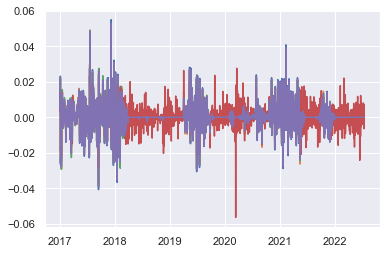

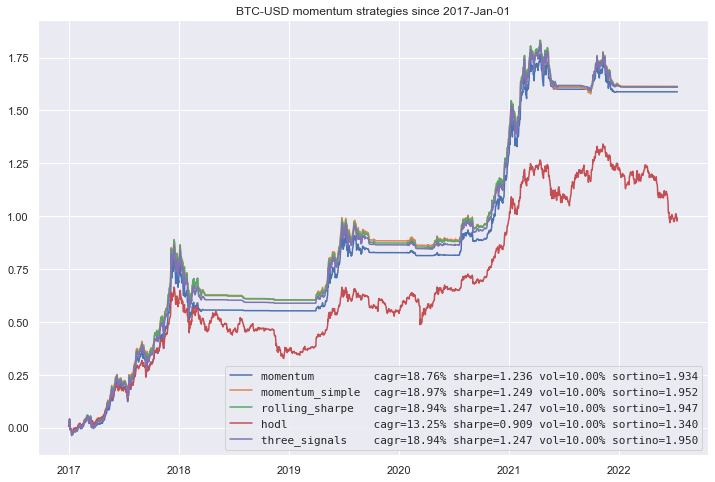

In [3]:
print('sharpe={}'.format(stock.sharpe()))
print('return={}'.format((stock+1).prod()-1))
def no_signal(returns=stock,rolling_period=30):
    return returns.rolling(rolling_period).apply(lambda x: 1)

rolling_period = 21*6
signals={'momentum':{'function':qs.stats.momentum},'momentum_simple':{'function':qs.stats.momentum_simple}\
    ,'rolling_sharpe':{'function':qs.stats.rolling_sharpe}\
    ,'hodl':{'function':no_signal}\
        }
for name,signal in signals.items():
    signal['metric'] = signal['function'](returns=stock,rolling_period=rolling_period)
    print('{:16s} mean={}'.format(name,signal['metric'].mean()))
    plt.plot(signal['metric'],label=name)
plt.legend(prop={'family' : 'monospace'})
plt.title('Metric')
plt.show()

shift_amount=1
min_clip=0
max_clip=2
add_amount=0
divide_amount=1
start_date = pd.to_datetime('2017-01-01')
stock_series = stock.loc[stock.index>=start_date]
label = '{:16s} cagr={:6.2%} sharpe={:5.3f} vol={:6.2%} sortino={:5.3f}'

returns=stock_series
metrics=stock_series
for name,signal in signals.items():
    signal['signal'] = signal['metric'].shift(shift_amount)
    signal['signal'] = np.clip(signal['signal'],min_clip,max_clip)
    signal['signal'] = (signal['signal']+add_amount)/divide_amount
    # signal['signal'] = signal['signal'].loc[stock.index>=start_date]
    signal['signal'] = signal['signal']*signals['momentum']['signal'].mean()/signal['signal'].mean()
    print('{:16s} signal mean={}'.format(name,signal['signal'].mean()))
    signal['return'] = stock_series*(signal['signal'].loc[stock.index>=start_date])
    signal['return'] = signal['return']*0.1/qs.stats.volatility(signal['return']) # normalize to 10% volatility
    returns=pd.concat([returns,signal['return']],axis=1)
    metrics=pd.concat([metrics,signal['metric']],axis=1)
display(returns.head(2))
display(metrics.tail(2))

# add a new signal
signals['three_signals']={'return':signals['hodl']['metric'].loc[stock.index>=start_date]-1}
# display(signals['three_signals'])
for name,signal in signals.items():
    if name!='hodl':
        signals['three_signals']['return']=signals['three_signals']['return']+signal['return']/len(signals.items())
signals['three_signals']['return']=signals['three_signals']['return']*0.1/qs.stats.volatility(signals['three_signals']['return'])
for name,signal in signals.items():
    plt.plot(signal['return'],label=name)

plt.figure(figsize=(12,8))
for name,signal in signals.items():
    labelText = label.format(name,qs.stats.cagr(signal['return']),qs.stats.sharpe(signal['return']),qs.stats.volatility(signal['return']),qs.stats.sortino(signal['return']))
    print(labelText)
    plt.plot(qs.stats.compsum(signal['return']),label=labelText)
plt.legend(prop={'family' : 'monospace'})
plt.title('{} momentum strategies since {:%Y-%b-%d}'.format(tickerName,start_date))
plt.show()

In [15]:
# tickerList = ['TFLO','EMBH','IBTA.L','IBTU.L','SHV','DFNM']
tickerList = ['TFLO','IBTA.L','IBTU.L','SHV','USFR','PVI','OPER']
# tickerList = ['VHT','VOO']

stocks = pd.DataFrame()
startDates = dict()
for i in tickerList:
    newStock = qs.utils.download_returns(i)
    stocks = pd.concat([stocks, newStock], axis=1)
    startDates[i]=newStock.index[0]

In [16]:
stocks.columns = tickerList
display(stocks.tail(3))
display(startDates)
display(startDates.keys())
maxStartDate = max(startDates.values())
display(maxStartDate)

,TFLO,IBTA.L,IBTU.L,SHV,USFR,PVI,OPER
2022-07-11 00:00:00,-0.000198,0.001919,0.0000,-0.000182,0.000000,-0.000402,0.00005
2022-07-12 00:00:00,0.000000,-0.000192,-0.0001,-0.000091,-0.000199,0.000000,0.00005
2022-07-13 00:00:00,0.000000,-0.001533,-0.0001,-0.000182,0.000397,-0.000402,0.00019


{'TFLO': Timestamp('2014-02-04 00:00:00'),
 'IBTA.L': Timestamp('2017-04-13 00:00:00'),
 'IBTU.L': Timestamp('2019-02-20 00:00:00'),
 'SHV': Timestamp('2007-01-11 00:00:00'),
 'USFR': Timestamp('2014-02-04 00:00:00'),
 'PVI': Timestamp('2007-11-15 00:00:00'),
 'OPER': Timestamp('2018-07-11 00:00:00')}

dict_keys(['TFLO', 'IBTA.L', 'IBTU.L', 'SHV', 'USFR', 'PVI', 'OPER'])

Timestamp('2019-02-20 00:00:00')

In [17]:
print('utils')
print(vdir(qs.utils))
print('stats')
print(vdir(qs.stats))
print('plots')
print(vdir(qs.plots))
help(qs.stats.comp)
help(qs.utils.make_portfolio)

utils
['aggregate_returns', 'download_returns', 'exponential_stdev', 'group_returns', 'inspect', 'log_returns', 'make_index', 'make_portfolio', 'multi_shift', 'rebase', 'to_excess_returns', 'to_log_returns', 'to_prices', 'to_returns']
stats
['adjusted_sortino', 'autocorr_penalty', 'avg_loss', 'avg_return', 'avg_win', 'best', 'cagr', 'calmar', 'common_sense_ratio', 'comp', 'compare', 'compsum', 'conditional_value_at_risk', 'consecutive_losses', 'consecutive_wins', 'cpc_index', 'cvar', 'distribution', 'drawdown_details', 'expected_return', 'expected_shortfall', 'exposure', 'gain_to_pain_ratio', 'geometric_mean', 'ghpr', 'greeks', 'implied_volatility', 'information_ratio', 'kelly_criterion', 'kurtosis', 'max_drawdown', 'momentum', 'momentum_simple', 'monthly_returns', 'omega', 'outlier_loss_ratio', 'outlier_win_ratio', 'outliers', 'payoff_ratio', 'pct_rank', 'probabilistic_adjusted_sortino_ratio', 'probabilistic_ratio', 'probabilistic_sharpe_ratio', 'probabilistic_sortino_ratio', 'profit_

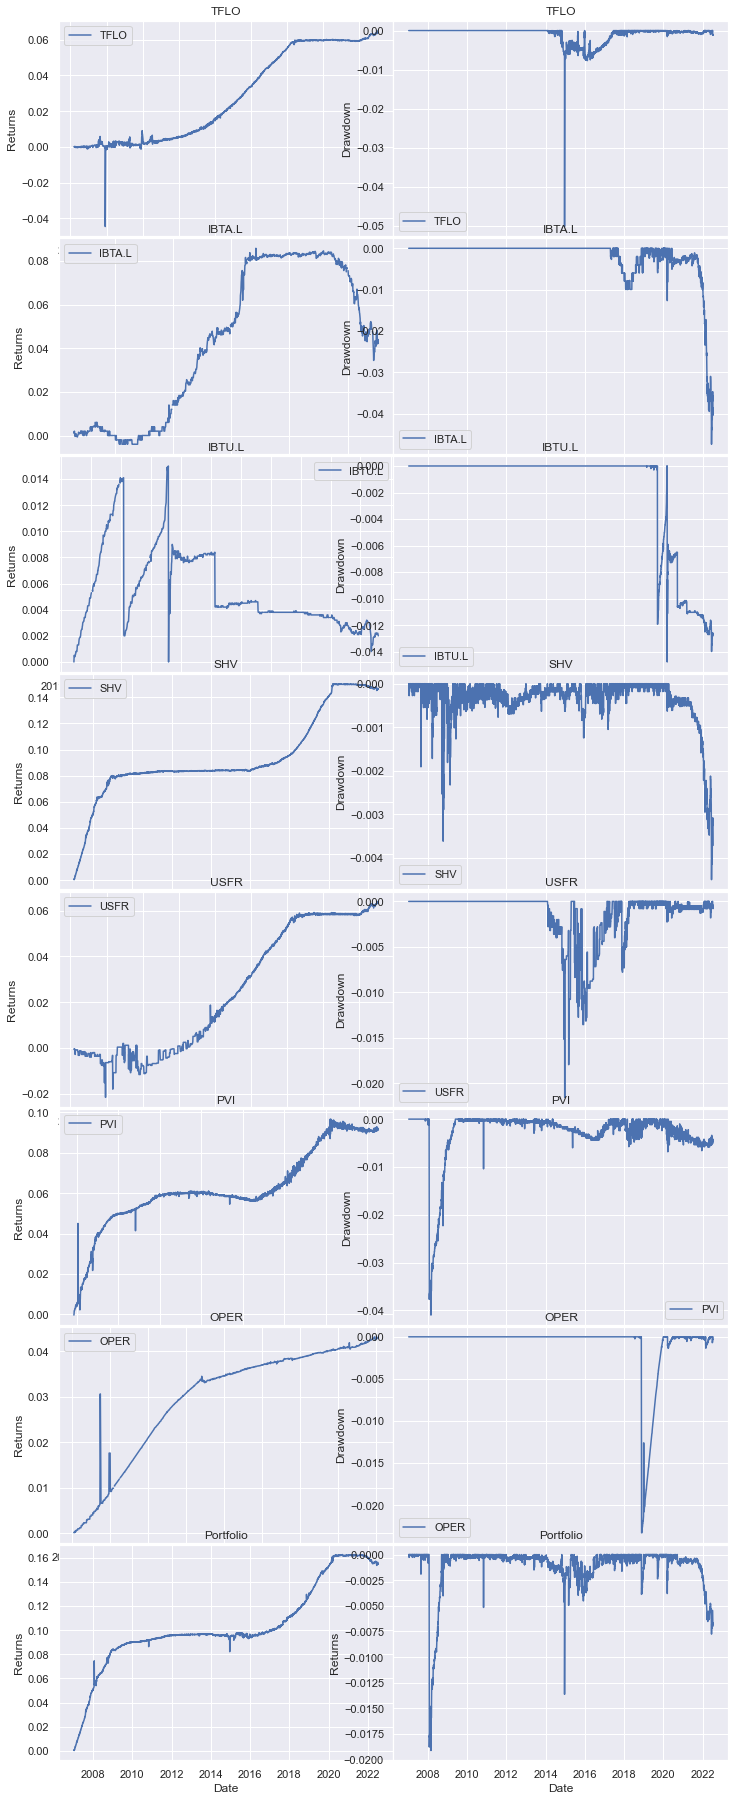

In [18]:
# portfolio = qs.utils.make_index(stocks)
n = stocks.shape[1]+1
# display(n)
portfolio = stocks.mean(axis=1)
fig, ax = plt.subplots(ncols=2, nrows=n,gridspec_kw = {'wspace':0, 'hspace':0.01}, figsize=(12,4*n))
fig.patch.set_facecolor('white')
for i, stock in enumerate(stocks.columns):
    ax[i,0].plot(qs.stats.compsum(stocks[stock]), label=stock)
    ax[i,0].legend()
    ax[i,0].set_title(stock)
    ax[i,0].set_xlabel('Date')
    ax[i,0].set_ylabel('Returns')
    ax[i,1].plot(qs.stats.to_drawdown_series(stocks[stock]), label=stock)
    ax[i,1].legend()
    ax[i,1].set_title(stock)
    ax[i,1].set_xlabel('Date')
    ax[i,1].set_ylabel('Drawdown')
    # ax[i].grid(visible=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
ax[n-1,0].plot(qs.stats.compsum(portfolio), label='Portfolio')
ax[n-1,0].set_title('Portfolio')
ax[n-1,0].set_xlabel('Date')
ax[n-1,0].set_ylabel('Returns')
ax[n-1,1].plot(qs.stats.to_drawdown_series(portfolio), label='Portfolio')
ax[n-1,1].set_title('Portfolio')
ax[n-1,1].set_xlabel('Date')
ax[n-1,1].set_ylabel('Returns')
plt.show()
# qs.plots.snapshot(portfolio, title='Performance')

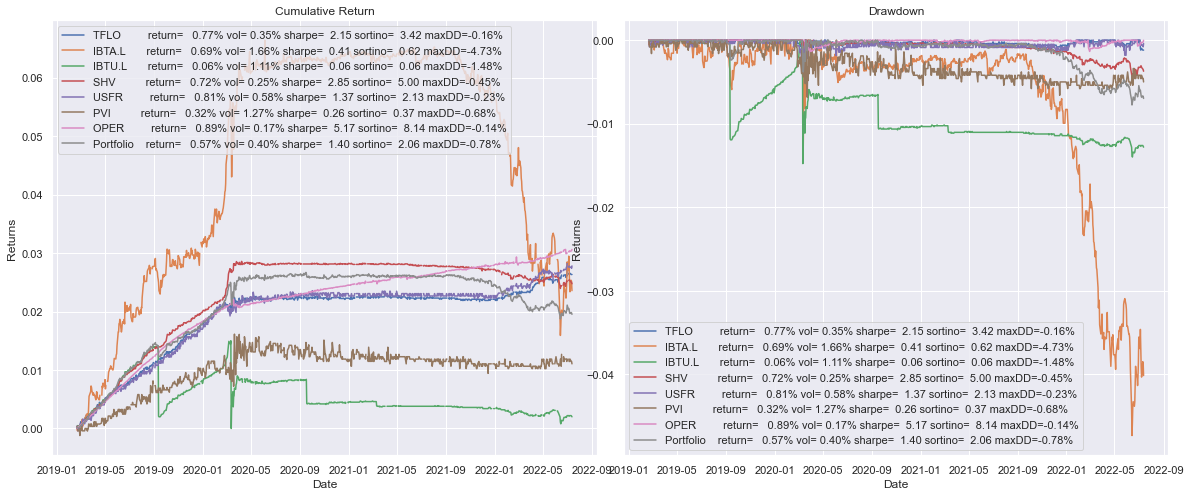

In [19]:
# portfolio = qs.utils.make_index(stocks)
n = stocks.shape[1]+1
# display(n)
labelFormat =  '{:12s} return={:8.2%} vol={:6.2%} sharpe={:6.2f} sortino={:6.2f} maxDD={:6.2%}'
portfolio = stocks.mean(axis=1)
fig, ax = plt.subplots(ncols=2, nrows=1,gridspec_kw = {'wspace':0.05, 'hspace':0.01}, figsize=(20,8))
fig.patch.set_facecolor('white')
for i, stock in enumerate(stocks.columns):
    relevantData = stocks[stock].loc[stocks[stock].index>=maxStartDate]
    relevantLabel = labelFormat.format(stock,qs.stats.cagr(relevantData),qs.stats.volatility(relevantData),qs.stats.sharpe(relevantData),qs.stats.sortino(relevantData),qs.stats.max_drawdown(relevantData))
    ax[0].plot(qs.stats.compsum(relevantData), label=relevantLabel)
    ax[0].set_title(stock)
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Percent Return')
    ax[1].plot(qs.stats.to_drawdown_series(relevantData), label=relevantLabel)
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Percentage Drawdown')
relevantData = portfolio.loc[portfolio.index>=maxStartDate]
relevantLabel = labelFormat.format('Portfolio',qs.stats.cagr(relevantData),qs.stats.volatility(relevantData),qs.stats.sharpe(relevantData),qs.stats.sortino(relevantData),qs.stats.max_drawdown(relevantData))
ax[0].plot(qs.stats.compsum(relevantData), label=relevantLabel)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns')
ax[0].legend()
ax[0].set_title('Cumulative Return')
ax[1].plot(qs.stats.to_drawdown_series(relevantData), label=relevantLabel)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Returns')
ax[1].legend()
ax[1].set_title('Drawdown')
plt.show()

In [20]:
# additional detail
# qs.stats.compsum(stocks.loc[stocks.index>=maxStartDate])
# for stock in tickerList:
#     display(qs.reports.full(returns=stocks.loc[stocks[stock].index>=maxStartDate,stock]))

In [21]:
# report = qs.reports.metrics(mode='full', returns=stock)

In [11]:
# qs.reports.plots(mode='full', returns=stock) # shows basic/full metrics

In [12]:
# qs.reports.basic(returns=stock) # shows basic metrics and plots

                           Strategy
-------------------------  ----------
Start Period               2007-01-11
End Period                 2022-07-13
Risk-Free Rate             0.0%
Time in Market             18.0%

Cumulative Return          4.31%
CAGR﹪                     0.27%

Sharpe                     0.3
Prob. Sharpe Ratio         87.28%
Smart Sharpe               0.3
Sortino                    0.44
Smart Sortino              0.44
Sortino/√2                 0.31
Smart Sortino/√2           0.31
Omega                      1.91

Max Drawdown               -2.33%
Longest DD Days            406
Volatility (ann.)          0.91%
Calmar                     0.12
Skew                       2.1
Kurtosis                   1528.99

Expected Daily %           0.0%
Expected Monthly %         0.02%
Expected Yearly %          0.26%
Kelly Criterion            37.45%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.09%
Expected Shortfall (cVaR)  -0.09%

Max Consecutive Wins       78
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-11-19,2018-11-19,2019-12-30,406,-2.328536,-2.287776
2,2020-03-18,2020-04-01,2020-06-23,97,-0.135720,-0.130744
3,2022-02-25,2022-02-28,2022-05-12,76,-0.134761,-0.109805
4,2022-06-28,2022-06-28,2022-07-13,15,-0.069870,-0.059887
5,2021-03-03,2021-03-12,2021-03-17,14,-0.054946,-0.014988


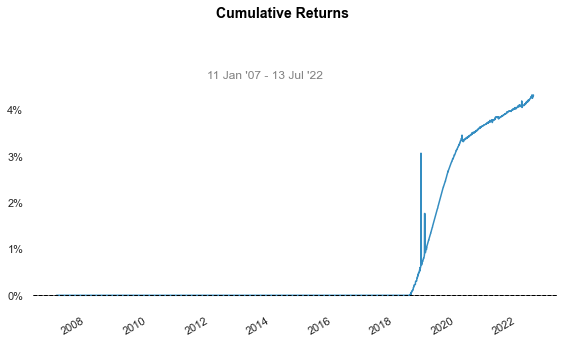

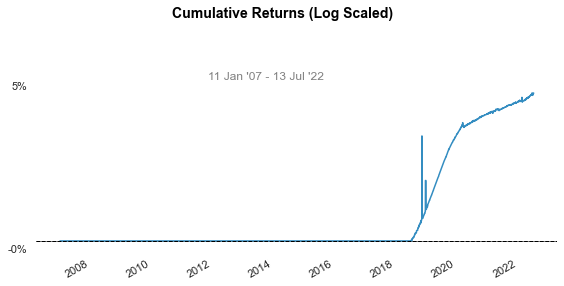

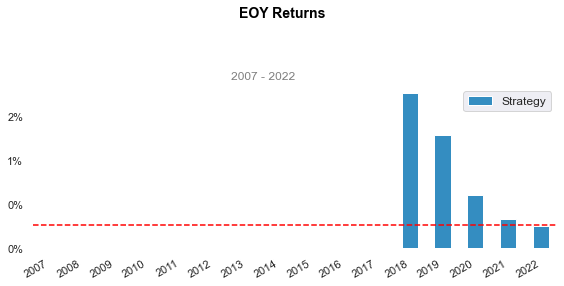

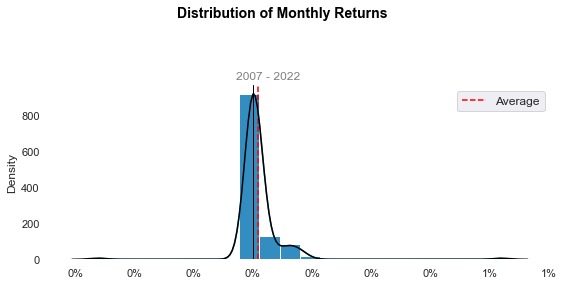

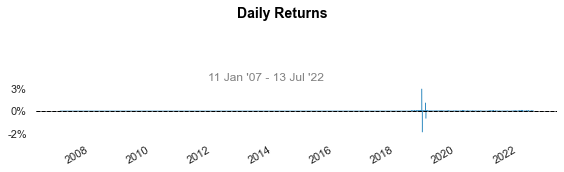

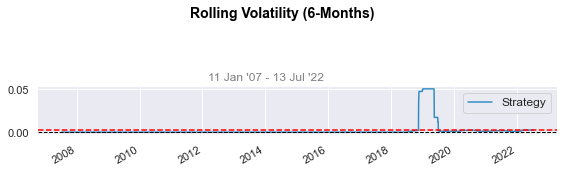

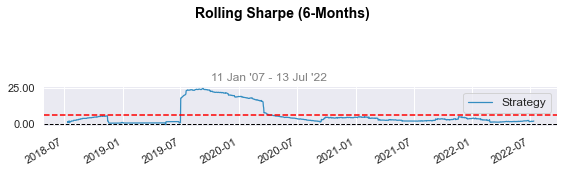

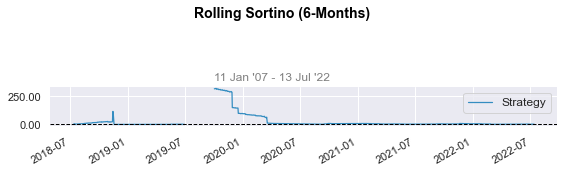

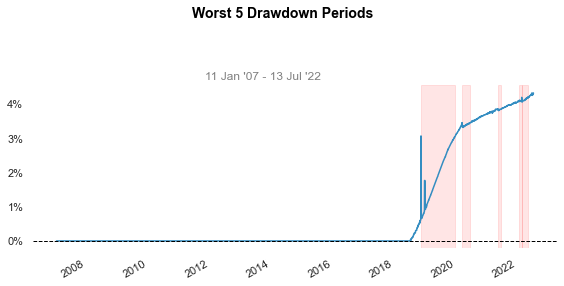

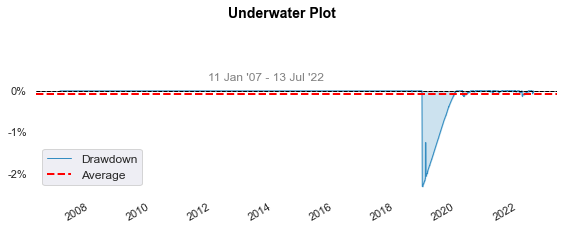

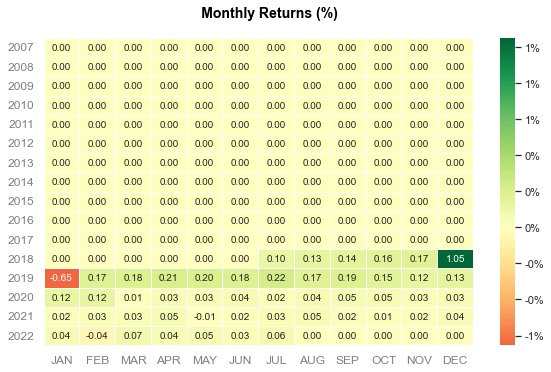

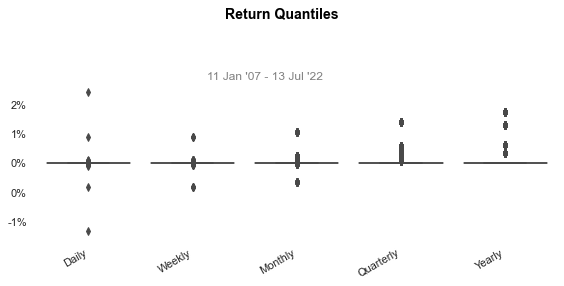

In [24]:
qs.reports.full(returns=stocks.loc[:,'OPER']) # shows full metrics and plots

In [14]:
# qs.reports.html(returns=stock) # generates a complete report as html